In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import scipy.stats as stats
from scipy.optimize import curve_fit
import scipy.io as sio

from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import  matplotlib.markers as mark


from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib import cm

import os
from os.path import expanduser

import pickle

from sklearn.decomposition import PCA

import torch
# from tqdm import tqdm

# from rnn_hierarchical_withTau import RNN_stack

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [58]:
ft = 14
# graphical properties
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': ft})
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['pdf.fonttype'] = 42 # prepare as vector graphic
plt.rcParams['ps.fonttype'] = 42

plt.rcParams["font.family"] = "Helvetica"


save_fig_path = expanduser("~") + '/research/data/projects/rnn_timescales/neurips_23/'

col_sig_par = '#D48A6A' #, if too light #AA5B39
col_sig_dms = '#803515'

col_multi_par =  '#74AE97' #, if too light #277455
col_multi_dms =  '#0E573A'

# Load data

In [4]:
num_neurons = 500
NET_SIZE = [num_neurons]

INPUT_SIZE = 1
NUM_CLASSES = 2
BIAS = True
NUM_READOUT_HEADS = 100
TRAIN_TAU = True


## load taus

In [48]:
path_parity = expanduser("~") + '/research/projects/rnn_timescales_local/Hel/n_bit_parity/ac_all_taus_minlag0/'
# path_dms = expanduser("~") + '/research/projects/rnn_timescales_local/Hel/n_bit_parity/ac_all_taus_bdms_minlag0/'

In [41]:
def load_taus(network_name, sub_dir, N, path):
    
    with open(path + network_name + '_N' + str(N) + sub_dir + '_ac_taus.pkl', 'rb') as f:
            data = pickle.load(f)
    selected_taus = data['selected_taus']
    selected_models = data['selected_models']
    trained_taus = data['trained_taus']
    single_acs = data['ac_all']
    ac_pop = data['ac_pop']
    
    tau_eff = []
    for i in range(len(trained_taus)):
        if selected_models[i] == 1:
            tau_eff.append(selected_taus[i])
        else:
            tau_eff.append(selected_taus[i][1])
            
    tau_eff = np.array(tau_eff)
    return tau_eff, selected_taus, selected_models, trained_taus, single_acs, ac_pop


In [42]:
def compute_mean_std_tau(net_ids, N_range, sub_dir, path):
    tau_mean_mean = np.zeros(len(N_range))
    tau_std_mean = np.zeros(len(N_range)) 
    tau_mean_std = np.zeros(len(N_range))
    tau_std_std = np.zeros(len(N_range))
    for i, N in enumerate(N_range):
        train_taus_all = []
        eff_taus_all = []
        eff_taus_net_avg = np.zeros(len(net_ids))
        eff_taus_net_std = np.zeros(len(net_ids))
        for j, net_id in enumerate(net_ids):
            network_name = 'network_'+str(net_id)
            tau_eff, selected_taus, selected_models, trained_taus, single_acs, ac_pop =\
            load_taus(network_name, sub_dir, N, path)
    #         tau_eff = tau_eff[(tau_eff>1)& (tau_eff<99)]
            tau_eff = tau_eff[(tau_eff>1)]

            eff_taus_net_avg[j] = np.mean(tau_eff)
            eff_taus_net_std[j] = np.std(tau_eff)

        tau_mean_mean[i] = np.mean(eff_taus_net_avg)
        tau_std_mean[i] = np.std(eff_taus_net_avg)
        tau_mean_std[i] = np.mean(eff_taus_net_std)
        tau_std_std[i] = np.std(eff_taus_net_std)
        
    return tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std

In [51]:
def load_taus_new(path, curriculum_type, task, affixes, network_number, N):
    
    affix_str = '_'
    if len(affixes) > 0:
        affix_str += '_'.join(affixes) + '_'
    
    model_name = os.path.join(
        f'{curriculum_type}_{task}{affix_str}network_{network_number}')
    
    with open(path + model_name +'_N'+str(N) + '_acs_taus.pkl', 'rb') as f:
            data = pickle.load(f)
    tau_eff = data['taus_net']
    selected_models = data['selected_models']
    trained_taus = data['taus_trained']
    single_acs = data['ac_all']
    ac_pop = data['ac_pop']
    
            
#     tau_eff = np.array(tau_eff)
    return tau_eff, selected_models, trained_taus, single_acs, ac_pop 

def compute_mean_std_tau_eff(net_ids, N_range, path, curriculum_type, task, affixes):
    tau_mean_mean = np.zeros(len(N_range))
    tau_std_mean = np.zeros(len(N_range)) 
    tau_mean_std = np.zeros(len(N_range))
    tau_std_std = np.zeros(len(N_range))
    for i, N in enumerate(N_range):
        train_taus_all = []
        eff_taus_all = []
        eff_taus_net_avg = np.zeros(len(net_ids))
        eff_taus_net_std = np.zeros(len(net_ids))
        for j, net_id in enumerate(net_ids):
            network_name = 'network_'+str(net_id)
            tau_eff, selected_models, trained_taus, single_acs, ac_pop =\
            load_taus_new(path, curriculum_type, task, affixes, net_id, N)
    #         tau_eff = tau_eff[(tau_eff>1)& (tau_eff<99)]
            tau_eff = tau_eff[(tau_eff>1)]

            eff_taus_net_avg[j] = np.mean(tau_eff)
            eff_taus_net_std[j] = np.std(tau_eff)

        tau_mean_mean[i] = np.mean(eff_taus_net_avg)
        tau_std_mean[i] = np.std(eff_taus_net_avg)
        tau_mean_std[i] = np.mean(eff_taus_net_std)
        tau_std_std[i] = np.std(eff_taus_net_std)
        
    return tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std


def compute_mean_std_tau_train(net_ids, N_range, path, curriculum_type, task, affixes):
    tau_mean_mean = np.zeros(len(N_range))
    tau_std_mean = np.zeros(len(N_range)) 
    tau_mean_std = np.zeros(len(N_range))
    tau_std_std = np.zeros(len(N_range))
    for i, N in enumerate(N_range):
        train_taus_all = []
        train_taus_all = []
        train_taus_net_avg = np.zeros(len(net_ids))
        train_taus_net_std = np.zeros(len(net_ids))
        for j, net_id in enumerate(net_ids):
            network_name = 'network_'+str(net_id)
            tau_eff, selected_models, trained_taus, single_acs, ac_pop =\
            load_taus_new(path, curriculum_type, task, affixes, net_id, N)

            train_taus_net_avg[j] = np.mean(trained_taus)
            train_taus_net_std[j] = np.std(trained_taus)

        tau_mean_mean[i] = np.mean(train_taus_net_avg)
        tau_std_mean[i] = np.std(train_taus_net_avg)
        tau_mean_std[i] = np.mean(train_taus_net_std)
        tau_std_std[i] = np.std(train_taus_net_std)
        
    return tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std

In [23]:
def plot_shade(x, mean, std, color):
    ax.fill_between(
        x,
        mean - std,
        mean + std,
        color=color,
        alpha=0.3,
    )

<ErrorbarContainer object of 3 artists>

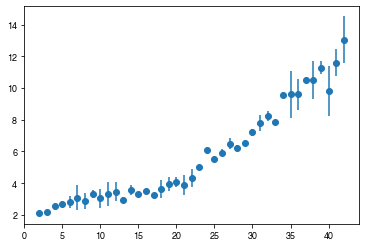

In [33]:
net_ids = [0,2] #np.arange(4)
N_range = np.arange(2,43,1)

curriculum_type = 'single'
task = 'parity'
affixes = ['mod', 'leakyrelu']
path = path_parity

tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  = \
compute_mean_std_tau(net_ids, N_range, path, curriculum_type, task, affixes)
plt.errorbar(N_range, tau_mean_mean, yerr = tau_std_mean, fmt = 'o')

# Plot

In [49]:
lw = 1

path_parity_new = expanduser("~") + '/research/data/projects/rnn_timescales/ac/ac_tau_loc_nonlin_correct/'
task = 'parity'
affixes = ['mod', 'leakyrelu']
path = path_parity_new

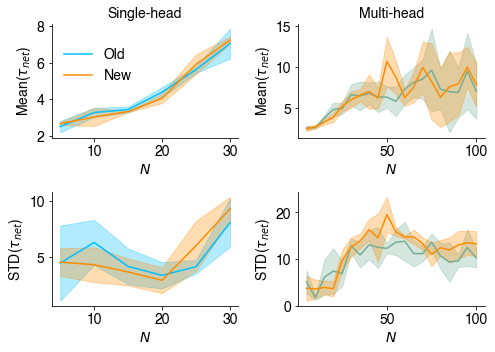

In [63]:
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(18*cm, 13*cm))


alpha_dot = 0.6
w = 0.35 #width of mean line
ms = 8
lw = 2

x_text = -.4
y_text = 1.1

x_noise = 0.05
c_singlehead = '#D48A6A'
c_multihead = '#489174'
#c_trained = '#5A78E6'
c_new = 'darkorange'
c_old = 'deepskyblue'


ms = 3
lw = 1.5
elw = 1.5

y1 = .9
y2 = 2

ax = plt.subplot(221)
# ax.text(x_text,y_text,'b',color='k',fontsize=ft+1,weight='bold', transform=ax.transAxes)

net_ids = np.arange(1,5)

# single, old
net_ids = np.arange(1,5)
N_range = np.arange(5,35,5)
sub_dir = ''
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau(net_ids, N_range, sub_dir, path_parity)
plt.plot(N_range, tau_mean_mean, color = c_old, label = 'Old')
plot_shade(N_range, tau_mean_mean, tau_std_mean, c_old)


# single, new
net_ids = [0,2,3]
# N_range = np.arange(2,31,1)
curriculum_type = 'single'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_eff(net_ids, N_range, path, curriculum_type, task, affixes)
plt.plot(N_range, tau_mean_mean, color = c_new, lw = lw, label = 'New')
plot_shade(N_range, tau_mean_mean, tau_std_mean, c_new)

plt.ylabel(r'Mean($\tau_{net}$)')
plt.xlabel(r'$N$')
plt.title('Single-head', fontsize = ft)
# plt.ylim([y1, y2])

plt.legend(frameon = False, loc = 'upper left', bbox_to_anchor=(0,.9))

ax = plt.subplot(222)
net_ids = np.arange(1,5)
# ax.axhline(y = 1, ls = '--', color = 'gray')


# multi, old
net_ids = np.arange(1,5)
N_range = np.arange(5,101,5)
sub_dir = '_train_curr_cumulative_1_heads'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau(net_ids, N_range, sub_dir, path_parity)
plt.plot(N_range, tau_mean_mean, color = col_multi_par, label = '$N$-parity')
plot_shade(N_range, tau_mean_mean, tau_std_mean, col_multi_par)


# Parity, multi
net_ids = np.arange(0,4)
# N_range = np.arange(2,101,1)
curriculum_type = 'cumulative'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_eff(net_ids, N_range, path, curriculum_type, task, affixes)
plt.plot(N_range, tau_mean_mean, color = c_new, lw = lw, label = 'Multi-N')
plot_shade(N_range, tau_mean_mean, tau_std_mean, c_new)

plt.title('Multi-head', fontsize = ft)


fig.tight_layout()
# plt.legend(frameon = False, loc = 'upper right', bbox_to_anchor=(1,1.1))
plt.xlabel(r'$N$')
# plt.title('Multi-head', fontsize = ft)
plt.ylabel(r'Mean($\tau_{net}$)')
plt.xlabel(r'$N$')
# plt.ylim([y1, y2])

#-------------------------------------------------------------------------------------------------------

ax = plt.subplot(223)
net_ids = np.arange(1,5)

y1 = 0.2
y2 = 1.2

# single, old
net_ids = np.arange(1,5)
N_range = np.arange(5,35,5)
sub_dir = ''
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau(net_ids, N_range, sub_dir, path_parity)
plt.plot(N_range, tau_mean_std, color = c_old, label = 'Old')
plot_shade(N_range, tau_mean_std, tau_std_std, c_old)

# single, new
net_ids = [0,2,3]
# N_range = np.arange(2,31,1)
curriculum_type = 'single'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_eff(net_ids, N_range, path, curriculum_type, task, affixes)
plt.plot(N_range, tau_mean_std, color = c_new, lw = lw, label = 'New')
plot_shade(N_range, tau_mean_std, tau_std_std, c_new)

# plt.legend(frameon = False, loc = 'upper left', bbox_to_anchor=(0,1.1))
plt.ylabel(r'STD($\tau_{net}$)')
plt.xlabel(r'$N$')
# plt.title('Single-head', fontsize = ft)

ax = plt.subplot(224)
net_ids = np.arange(1,5)


# multi, old
net_ids = np.arange(1,5)
N_range = np.arange(5,101,5)
sub_dir = '_train_curr_cumulative_1_heads'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau(net_ids, N_range, sub_dir, path_parity)
plt.plot(N_range, tau_mean_std, color = col_multi_par, label = '$N$-parity')
plot_shade(N_range, tau_mean_std, tau_std_std, col_multi_par)


# Parity, multi
net_ids = np.arange(0,4)
# N_range = np.arange(2,101,1)
curriculum_type = 'cumulative'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_eff(net_ids, N_range, path, curriculum_type, task, affixes)
plt.plot(N_range, tau_mean_std, color = c_new, lw = lw, label = 'Multi-N')
plot_shade(N_range, tau_mean_std, tau_std_std, c_new)

# plt.legend(frameon = False, loc = 'upper right', bbox_to_anchor=(1,1.1))
plt.ylabel(r'STD($\tau_{net}$)')
plt.xlabel(r'$N$')
# plt.title('Multi-head', fontsize = ft)
# plt.ylim([y1, y2])
# plt.legend(frameon = False, loc = 'upper right', bbox_to_anchor=(1.1,1.5),\
#            handletextpad= 0.2, handlelength = 0.8, ncol = 4, columnspacing=0.7)


fig.tight_layout()

sns.despine()